# The Traveling Salesperson Problem

Consider the [*Traveling Salesperson Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (or TSP): 

> *Given a set of cities and the distance between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

In this notebook we will develop some solutions to the problem, and more generally show *how to think about* solving  problems. The algorithms developed here are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day.

|![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)|
|---|
|[An example tour](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)|

                                     
# Understanding What We're Talking About

Do we understand the problem statement well enough to program a solution? Let's check:

- ***Given a set of cities***
<br>A Python `set` could represent a set of cities. An individual city might be just an integer index, or it might be (x, y) coordinates.
- ... ***and the distance between each pair of cities***: 
<br>We could use either a function, `distance(A, B),` or a table, `distance[A, B]`.
- ... ***what is the shortest possible tour***
<br>A tour is a sequential order in which to visit the cities; a function `shortest_tour(tours)` should find the one that minimizes `tour_length(tour)`, which is the sum of the distances between adjacent cities in the tour. 
- ... ***that visits each city once and returns to the starting city***
<br>Make sure a tour doesn't re-visit a city (except returning to the start). 



I don't yet have all the answers, but I'm ready to attack the problem. 

In [1]:
# Imports used in this notebook. This is Python 3 on Jupyter with matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt
import random
from time        import clock 
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median

# Exhaustive Search Algorithm: `exhaustive_tsp`

Let's start with an algorithm that is *guaranteed* to solve the problem, although inefficiently:

> **Exhaustive Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest tour (the one with minimum tour length).*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description. This will probably require some auxilliary functions and data structures; just assume they exist; put them on a TO DO list, and eventually define them with the same design philosophy:

In [2]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

This gives us a good start; the Python code closely matches the English description.  Now for the TO DO list.

**Cities:** the only thing we need to know about a city is its distance to other cities. We don't need to know the city's name, population, best restaurants, or anything else.  We'll assume the distance between two cities is the [Euclidean distance](http://en.wikipedia.org/wiki/Euclidean_distance), the straight-line distance between points in a two-dimensional plane. So I want `City(300, 100)` to be the city with x-coordinate 300 and y coordinate 100. At first glance it seems like Python does not have a builtin type for a point in the two-dimensional plane, but actually there is one: complex numbers. I'll implement `City` with `complex`, which means the distance between two cities, `distance(A, B)`, is the absolute value of the vector difference between them. 

I'll also define `Cities(n)` to make a set of `n` random cities. I want `Cities` to be reproducible (to return the same result when called with the same arguments), so I provide a keyword argument that sets `random.seed`. 

In [3]:
City = complex

def Cities(n, seed=123, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return frozenset(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))

def distance(A, B): return abs(A - B)

**Tours:** A tour that starts in city `1`, moves to `2`, then `3`, then back to `1` will be represented by  `(1, 2, 3)`. Any valid tour of a set of cities will be a *permutation* of the cities. That means we can implement `alltours` with the built-in `permutations` function (from the `itertools` module). 

The length of a tour is the sum of the distances between adjacent cities in the tour&mdash;the sum of the lengths of the **links** between cities in the tour. 

In [4]:
alltours = permutations 

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

# A solution!

Now we're ready: `exhaustive_tsp` can find a tour for a set of cities:

In [5]:
exhaustive_tsp(Cities(9))

((158+421j),
 (297+397j),
 (832+102j),
 (872+207j),
 (817+315j),
 (939+600j),
 (620+498j),
 (163+639j),
 (31+501j))

Quick, is that the shortest tour?  I can't tell. But this should help:

## Visualizing results: `plot_tour` and `do`


In [6]:
def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style)
    plot_segment(start, 'rD') # start city is red Diamond.
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

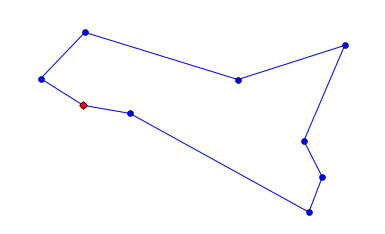

In [7]:
plot_tour(exhaustive_tsp(Cities(9)))

That looks much better!  It certainly looks like the shortest possible tour, although I can't prove it. 

*Vocabulary note:* A **segment** is a portion of a tour that does not loop back to the start. The **segment** `(1, 2, 3)` has only two links, 1-2 and 2-3, whereas the **tour** `(1, 2, 3)` has three links, because it includes the link back to the start, 3-1.

One more convenience: the function `do` runs a TSP algorithm on a set of cities, plots the tour, asserts it is valid, and prints summary information. 

In [8]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0   = clock()
    tour = algorithm(cities)
    t1   = clock()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')

exhaustive: 9 cities ⇒ tour length 2450 (in 1.229 sec)


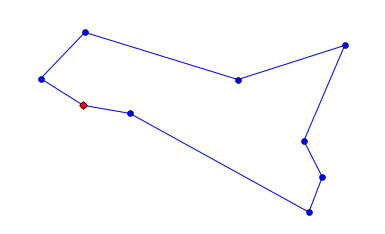

In [9]:
do(exhaustive_tsp, Cities(9))

## Optimization: non-redundant  `alltours`

We said there are *n*! tours of *n* cities, and thus 6 tours of 3 cities:

In [10]:
list(alltours({1, 2, 3}))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

But this is redundant: `(1, 2, 3)`, `(2, 3, 1)`, and `(3, 1, 2)` are three ways of describing the same tour. So let's arbitrarily say that a tour must start with the first city in the set of cities.  While we're redefining `alltours`, we'll take the opportunity to define a tour as a *list* rather than a *tuple*. It doesn't matter now, but I anticipate wanting to represent *partial* tours, to which we will append cities one by one; appending can be done to lists, but not tuples.

In [11]:
def alltours(cities):
    "Return a list of non-redundant tours (permutations of cities)."
    start, *others = cities
    return [[start] + Tour(perm) for perm in permutations(others)]
    
Tour = list  # A Tour is a list of cities

We can verify that for 3 cities there are now only 2 tours, and that `exhaustive_tsp` can now do 10 cities in about the time it took to do 9 before:

In [12]:
alltours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

exhaustive: 10 cities ⇒ tour length 2720 (in 1.553 sec)


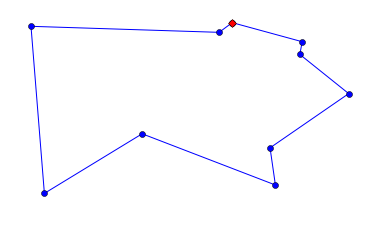

In [13]:
do(exhaustive_tsp, Cities(10))

# General Strategies

It takes Exhaustive Search 1 or 2 seconds to solve a 10-city problem. Since it looks at all permutations, an 11-city problem would take about 11 times longer, and a 15-city problem would take days.
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), *"when in doubt, use brute force."*
* **Approximation Strategy**: If it is too hard to find a precise, optimal solution, consider finding an approximate, suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that has the best gain. Repeat. 
* **Iterative Improvement Strategy**: Use an existing algorithm to create a solution, then have another algorithm improve the solution.
* **Ensemble Strategy**: Apply a set of algorithms to the problem, and pick the best solution. 
* **Divide and Conquer Strategy**: Split the problem in half, solve each half, and combine the two partial solutions.
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy (or modify).

Let's apply these strategies to develop some TSP algorithms.


# Nearest Neighbor Algorithm: `nn_tsp`

> **Nearest Neighbor Algorithm:** *Start at some city; at each step extend the tour by moving from the previous city to its nearest neighbor that has not yet been visited.*

This is an instance of both the **approximation strategy** and the **greedy strategy**, where we are being greedy about choosing the shortest link to a neighbor. So now, instead of considering all *n*! tours, we incrementally build a single tour. 
In  more detail:

* ***Start at some city***  (pass the start city as an argument, or if `None`, use the first city in the set)
* ***... at each step extend the tour*** (using `tour.append`)
* ***... by moving from the previous city*** (the previous city is `tour[-1]`)
* ***...to its nearest neighbor*** (as given by the function `nearest_neighbor`)
* ***...that has not yet been visited*** (I will maintain a set of `unvisited` cities)

In [14]:
def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city); 
    at each step extend the tour by moving from the previous city 
    to its nearest neighbor that has not yet been visited."""
    start = start or first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

While `exhaustive_tsp` was limited to about a dozen cities, this algorithm can do thousands of cities in less than a second:

nn: 1998 cities ⇒ tour length 33688 (in 0.539 sec)


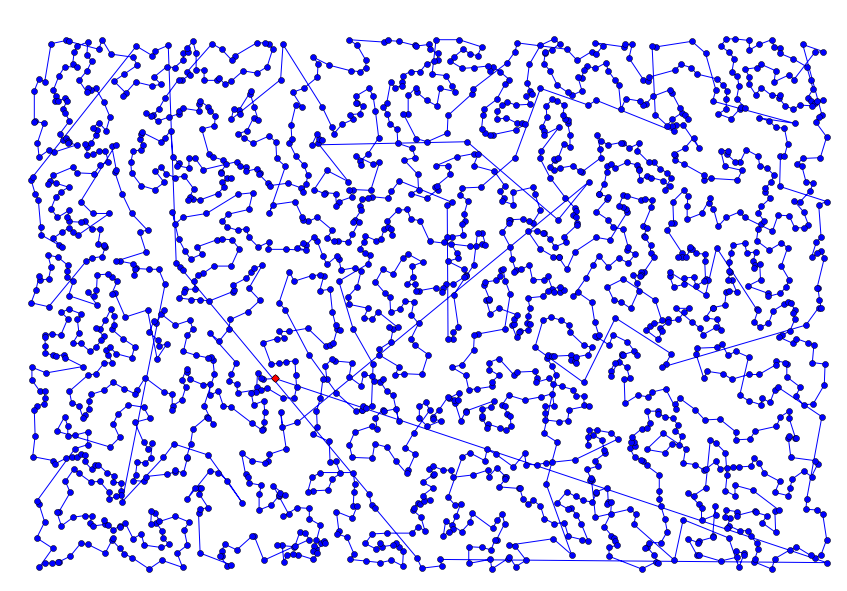

In [15]:
do(nn_tsp, Cities(2000))

(Note: I asked for 2000 cities but only got 1998 distinct ones&mdash;sometimes the random number generator produces the exact same city.)

nn: 10 cities ⇒ tour length 2792 (in 0.000 sec)


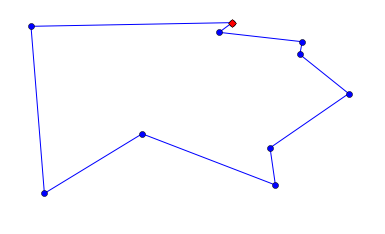

In [16]:
do(nn_tsp, Cities(10))

On `Cities(10)`, `nn_tsp` took almost no time, but the tour is not optimal: it is 3% longer than optimal. But that will vary, depending on the set of cities, and also depending on the starting city. So that gives me an idea: Just as with buying lottery tickets, we can improve our chance of winning by trying more often.

## Repetitive Nearest Neighbor Algorithm: `rep_nn_tsp`

> **Repetitive Nearest Neighbor Algorithm:** *Run the nearest neighbor algorithm repeatedly, each time with a different start city, and pick the resulting tour with the shortest total distance.*

This is an instance of the **ensemble strategy**, because providing a different paramater to the function each time is like using a different algorithm each time. Which starting cities should we pick? I'll define a function to randomly `sample` the cities (and for reproducibility I'll give it a `seed` argument, as I did with `Cities`). The parameter *k* says how many cities to sample.

In [17]:
def rep_nn_tsp(cities, k=25):
    "Repeat nn_tsp starting from k different cities; pick the shortest tour."
    return shortest_tour(nn_tsp(cities, start) for start in sample(cities, k))

def sample(population, k, seed=42):
    "Return a list of k elements sampled from population. Set random.seed."
    if k >= len(population): 
        return population
    else:
        random.seed((len(population), k, seed))
        return random.sample(population, k)

Let's try it:

rep_nn: 10 cities ⇒ tour length 2720 (in 0.000 sec)


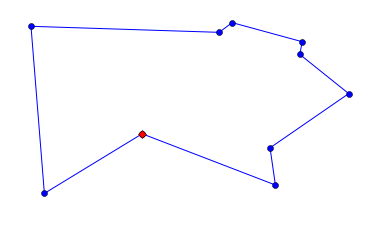

In [18]:
do(rep_nn_tsp, Cities(10))

rep_nn: 1998 cities ⇒ tour length 32327 (in 13.049 sec)


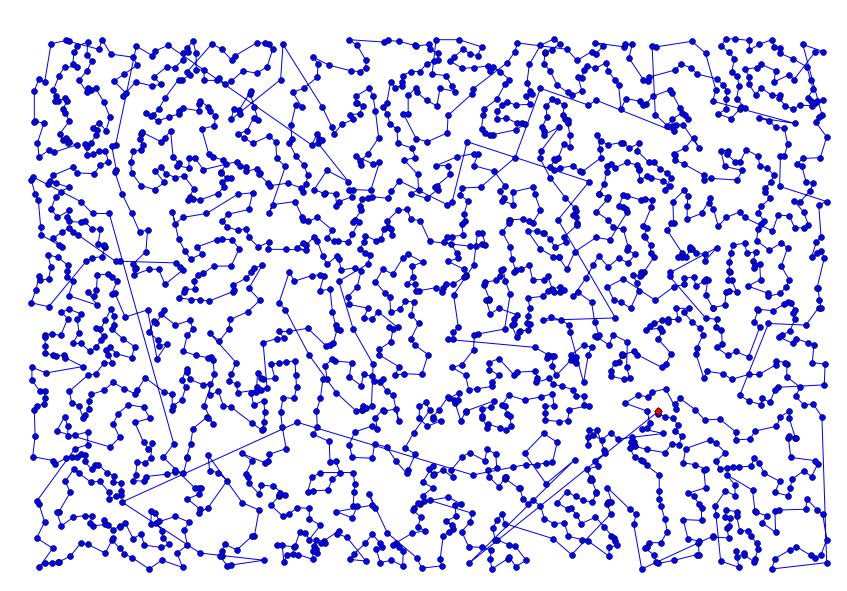

In [19]:
do(rep_nn_tsp, Cities(2000))

That's encouraging; it found the optimal tour for `Cities(10)` and it improved the `Cities(2000)` tour by 4%, although it does take *k* times longer to run. 

# Real Cities

Random cities are boring to look at; I thought it would be fun to work on some *real* cities. I found a web page (now 404, but a copy is [here](https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm)) that lists coordinates of over 10,000 cities in the USA, in this format:

    [TCL]  33.23   87.62  Tuscaloosa,AL
    [FLG]  35.13  111.67  Flagstaff,AZ
    [PHX]  33.43  112.02  Phoenix,AZ

I define the function `parse_cities` to take an iterable of lines and build a `City` out of each line that matches the format (excluding Alaska and Hawaii).

In [20]:
def continental_USA(line): 
    "Is this a line of the form '[TLA]  long lat City,ST'?"
    return line.startswith('[') and ',AK' not in line and ',HI' not in line
    
def parse_cities(lines, keep=continental_USA, long_scale=-48, lat_scale=69):
    """Make a set of Cities from lines of text."""
    return frozenset(City(long_scale * ncol(line, 2), lat_scale  * ncol(line, 1))
                     for line in lines if keep(line))

def ncol(line, n): "The number in the nth column"; return float(line.split()[n])

You might be wondering about the `long_scale=-48, lat_scale=69` part. The issue is that we have latitude and longitude for cities, and we want to compute the distance between cities. To do that accurately requires [complicated trigonometry](http://en.wikipedia.org/wiki/Haversine_formula).  But we can get an approximation by assuming that latitude and longitude are on a flat rectangular grid. (This is a bad approximation if you're talking about distances of 10,000 miles, but close enough for distances of 100 miles, as long as you're not too near the poles.)  I took the latitude of the center of the USA (Wichita, KS: latitude 37.65) and plugged it into a [Length Of A Degree Of Latitude
And Longitude Calculator](http://www.csgnetwork.com/degreelenllavcalc.html) to find that, in Wichita, one degree of latitude is 69 miles, and one degree of longitude is 48 miles.  (It is -48 rather than +48 because the USA is west of the prime meridian.) 

I also found a [blog post](http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/) by Randal S. Olson, who chose 50 landmarks across the USA and found a tour based on actual road-travel distances, not straight-line distance; I would need a new `distance` function to handle that. William Cook provides an
analysis, and a [tour that is shorter](http://www.math.uwaterloo.ca/tsp/usa50/index.html) than Randal's.

Now let's fetch the file (with a shell command); parse it; and find a baseline nearest neighbor tour:

In [21]:
! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm

nn: 1089 cities ⇒ tour length 52879 (in 0.170 sec)


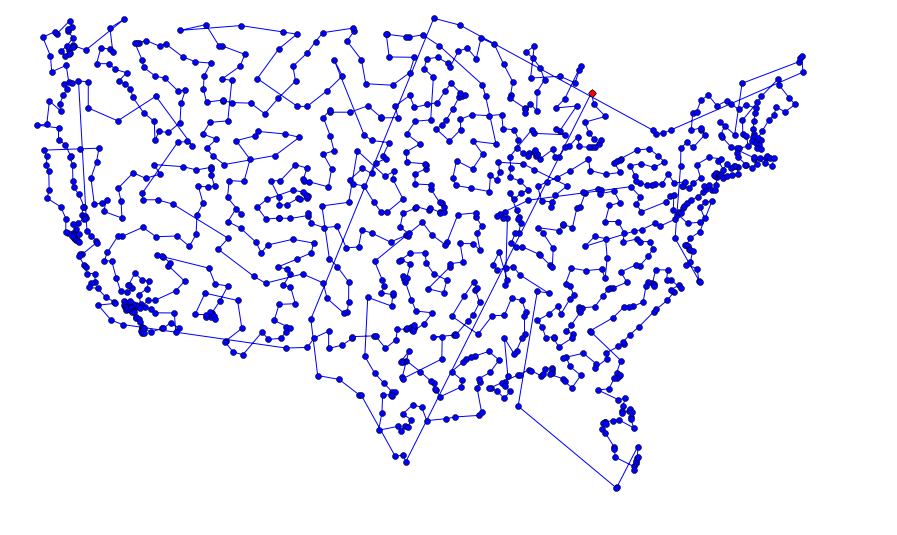

In [22]:
USA = parse_cities(open('latlong.htm'))

do(nn_tsp, USA)

# Improving Bad Links

There are some obviously bad (long) links in this tour. 
To understand the problem and how we might fix it, consider this simpler tour:

nn: 10 cities ⇒ tour length 17 (in 0.000 sec)


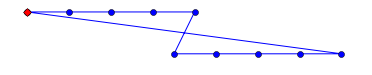

In [23]:
cities10 = {City(x, 1) for x in range(0, 5)} | {City(x - 1.49, 0) for x in range(5, 10)}

do(nn_tsp, cities10)

Starting at the upper left, the tour goes to the right, picking up the 5 cities in a line, jogs downward, and continues to the right, picking up the remaining 5 cities. But then it has a long diagonal link back to the start. Once you've seen this type of configuration a few times it becomes clear: *any time a tour has an "X" where two links cross, we can shorten the tour by uncrossing the "X".* 

You can think of uncrossing the X as deleting two links and adding two new ones. Or you can think of it as **reversing a segment**: this tour visits the bottom 5 cities in left-to-right order; let's reverse that segment and visit them in right-to-left order:

15.299342436137655

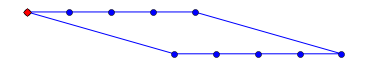

In [24]:
tour = nn_tsp(cities10)

tour[5:10] = reversed(tour[5:10])

plot_tour(tour)
tour_length(tour)

That's an improvement! 

Below is a diagram to explain why uncrossing the X is *always* an improvement. The four cities that form the cross are marked with red diamonds. The crossed lines that we will remove are dotted blue; the lines we will add are red. We can see that two red-and-blue triangles are formed, and by the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality) each red line is shorter than the two parts of the blue lines that make up the rest of the triangle.

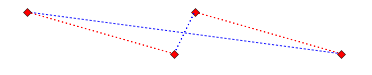

In [25]:
plot_tour([tour[4], tour[5]], 'r:');  plot_tour([tour[5], tour[0]], 'b:')
plot_tour([tour[0], tour[9]], 'r:');  plot_tour([tour[9], tour[4]], 'b:')


It is difficult to get nearest neighbors to avoid  mistakes (like crossing an X), because in the middle of the tour, when the algorithm is forced to make a choice, it doesn't know where the rest of the tour will end up. So, rather than tackling the difficult task of *avoiding* the mistakes, the **iterative improvement strategy** says to go ahead and make mistakes, finish the tour, and then do the much easier task of *fixing* the mistakes. Why is it easier to fix the mistakes? Because we can see the whole tour, so we can propose a change and get a definitive answer: either the change makes the whole tour shorter or it doesn't. The strategy is called *iterative* because we do multiple improvements, if possible.

The changes we propose will all consist of reversing segments; here is how we can check if reversing an arbitrary segment would be an improvement, and if it is, go ahead and do the reversal:

In [26]:
def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True

Now I'll define `improve_tour` to consider various segments, and reverse the ones that improve the tour. What segments should we consider? I don't know how to be clever about that, but I do know how to use **brute force**: try every subsegment. (I have an intuition (from experience with [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) that trying longer subsegments first would be better, so I'll write `subsegments` that way.) After I've tried all segments, if one of them did improve the tour that might open up new possibilities, so I'll repeat the process until there are no improvements, then return the improved tour:

In [27]:
def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

Here are all the subsegments of a 5 city tour:

In [28]:
subsegments(5)

[(1, 5), (0, 4), (2, 5), (1, 4), (0, 3), (3, 5), (2, 4), (1, 3), (0, 2)]

# Improved Nearest Neighbor Algorithms

Here are two ways of improving nearest neighbor algorithms&mdash;either improve the single nearest neighbor algorithm, or improve each candidate tour from the repetitive nearest neighbor algorithm:

In [29]:
def improve_nn_tsp(cities): 
    "Improve the tour produced by nn_tsp."
    return improve_tour(nn_tsp(cities))

def rep_improve_nn_tsp(cities, k=5):
    "Run nn_tsp from k different starts, improve each tour; keep the best."
    return shortest_tour(improve_tour(nn_tsp(cities, start)) 
                         for start in sample(cities, k))

improve_nn: 10 cities ⇒ tour length 15 (in 0.000 sec)


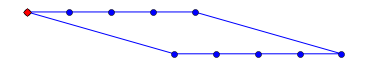

In [30]:
do(improve_nn_tsp, cities10)

improve_nn: 1089 cities ⇒ tour length 45489 (in 2.668 sec)


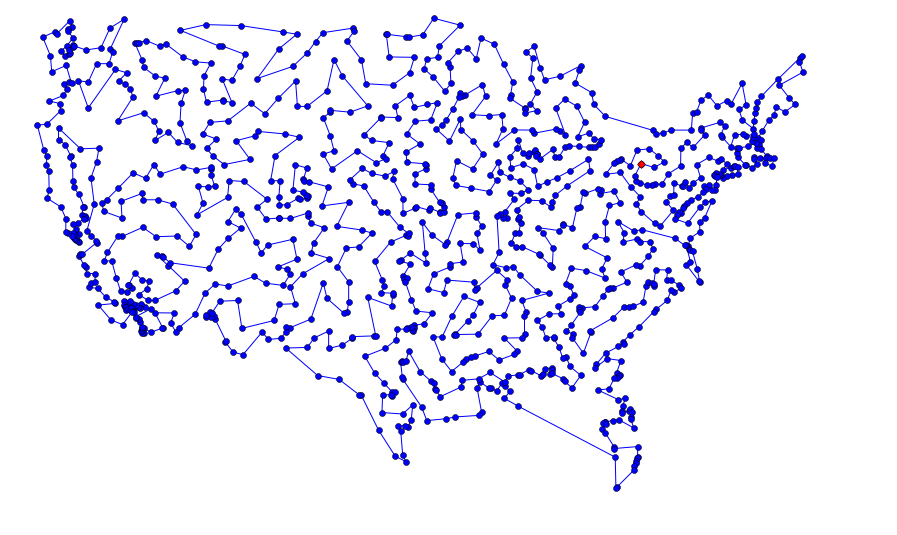

In [31]:
do(improve_nn_tsp, USA)

Not bad! A single call to `improve_tour` fixes the `cities10` problem, and on the USA map, uncrosses every X and saves over 7000 miles of travel! Let's try repetitions:

rep_improve_nn: 1089 cities ⇒ tour length 44901 (in 15.133 sec)


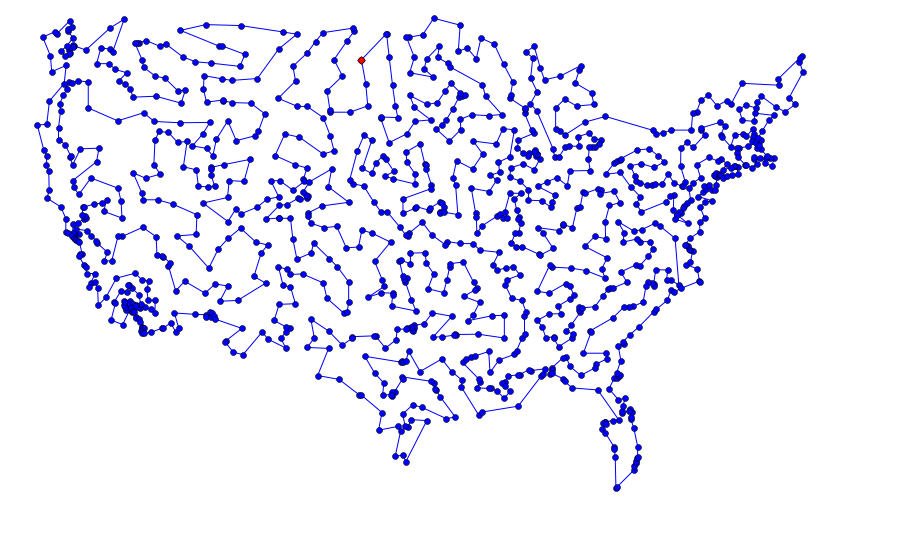

In [32]:
do(rep_improve_nn_tsp, USA)

We saved another 600 miles! Could we do better still by trying more repetitions? Maybe, but there's a problem: `do` doesn't accept extra arguments, so I can't change *k* from the default value of 5. I could modify `do`, but instead I'll define a [higher-order function](https://en.wikipedia.org/wiki/Higher-order_function), `bind`, so that `bind(rep_improve_nn_tsp, 5)`  creates a new function that calls `rep_improve_nn_tsp` with one extra argument (*k*) bound to 5. (My `bind` is similar to `functools.partial`, but does a better job with the function name of the newly created function.)

In [33]:
@cache()
def bind(fn, *extra):
    "Bind extra arguments; also assign .__name__"
    newfn = lambda *args: fn(*args, *extra)
    newfn.__name__ = fn.__name__  + ''.join(', ' + str(x) for x in extra)
    return newfn

rep_improve_nn, 12: 1089 cities ⇒ tour length 44622 (in 36.311 sec)


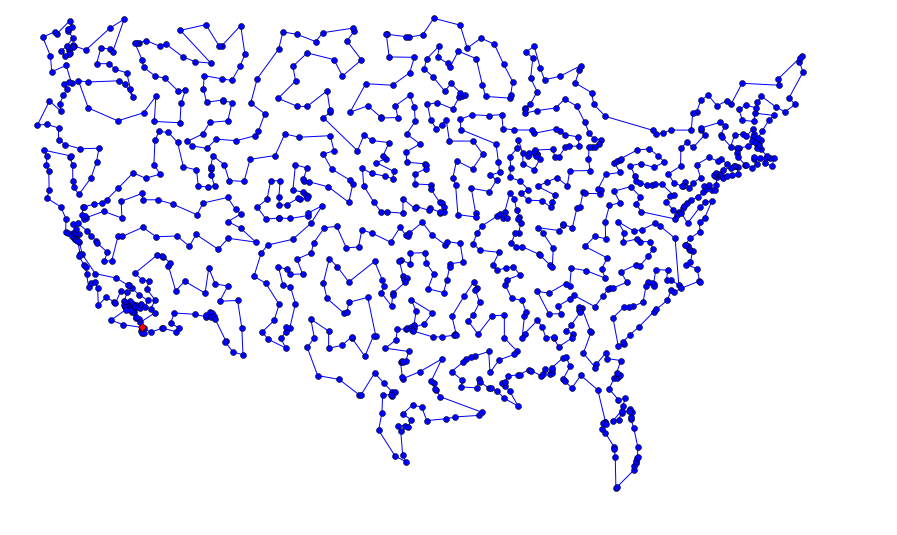

In [34]:
do(bind(rep_improve_nn_tsp, 12), USA)

We took another 300 miles off, but we may be at the point of diminishing returns. Let's try something new.

# Greedy Algorithm: `greedy_tsp`

We've covered the Nearest Neighbor Algorithm and some variations; now it is time to develop the so-called Greedy Algorithm, which (naturally) is an instance of the **greedy strategy**, this time  being greedy in adding the 
**shortest links**, not nearest neighbors.

> **Greedy Algorithm:** *Maintain a set of segments; intially each city defines its own 1-city segment. Find the shortest possible link that connects two endpoints of two different segments, and join those segments with that link. Repeat until we form a single segment that tours all the cities.*

On each step of the algorithm, we want to *"find the shortest possible link that connects two endpoints."* That seems like an expensive operation to do on each step. So we will add in some data structures  to speed up the computation:  

1. Pre-compute a list of links, sorted by shortest link first. A link is a pair of cities: `(A, B)`.
2. Maintain a dict that maps **endpoints** to **segments**, e.g. `{A: [A, B, C], C: [A, B, C], D: [D]}` means that `A` and `C` are the endpoints of segment `[A, B, C]` and `D` is a 1-city segment. 
3. Go through the links in shortest-first order. When you find a link like `(A, D)` such that `A` and `D` are endpoints of different segments, then join the two segments together.  Update the endpoints dict to reflect this new segment: `{A: [D, A, B, C], D: [D, A, B, C]}`.
4. Stop when the newly created segment contains all the cities.

Here is the code:


In [35]:
def greedy_tsp(cities):
    """Go through links, shortest first. Use a link to join segments if possible."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            if len(new_segment) == len(cities):
                return new_segment
            
def improve_greedy_tsp(cities): return improve_tour(greedy_tsp(cities))
            
def shortest_links_first(cities):
    "Return all links between cities, sorted shortest first."
    return sorted(combinations(cities, 2), key=lambda link: distance(*link))
            
# TO DO: join_endpoints

**Note:** The `endpoints` dict is serving two purposes. First, the keys of the dict are all the cities that are endpoints of some segment, making it possible to ask "`A in endpoints`" to see if city `A` is an endpoint. Second, the value of `endpoints[A]` is the segment that `A` is an endpoint of, making it possible to ask "`endpoints[A] != endpoints[B]`" to make sure that the two cities are endpoints of different segments, not of the same segment.

For the `join_endpoints` function, I first make sure that A is the last element of one segment and B is the first element of the other, by reversing segments if necessary.  Then I add the B segment on to the end of the A segment. Finally, I update the `endpoints` dict by deleting `A` and `B` and then adding the two endpoints of the new segment: 

In [36]:
def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

Let's try out the `greedy_tsp` algorithm, with and without improvement, on the USA map:

greedy: 1089 cities ⇒ tour length 46982 (in 0.604 sec)


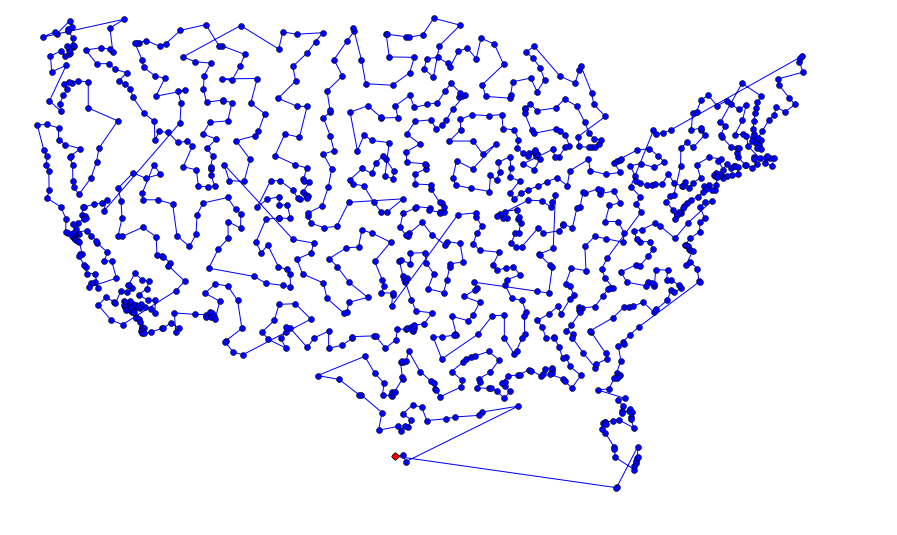

In [37]:
do(greedy_tsp, USA)

improve_greedy: 1089 cities ⇒ tour length 43844 (in 2.964 sec)


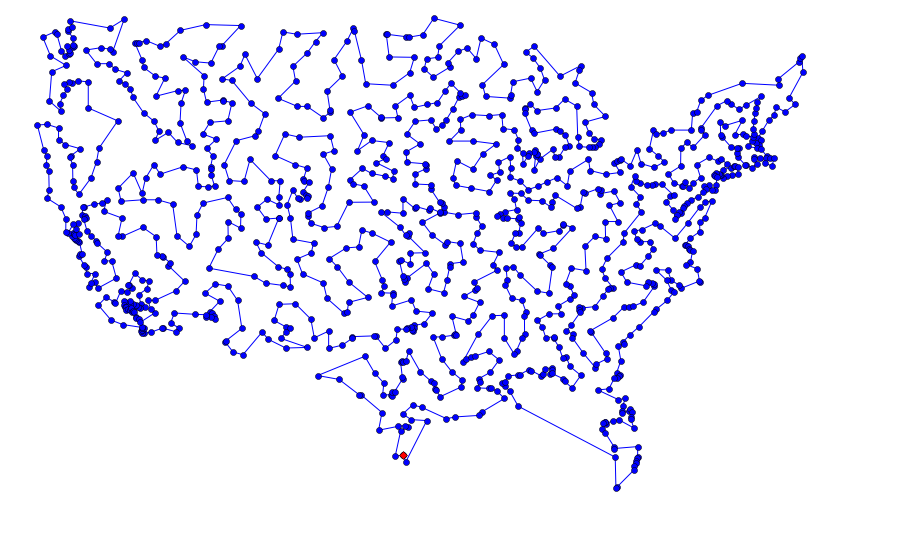

In [38]:
do(improve_greedy_tsp, USA)

That's the best result yet, knocking off another 800 miles!
What about a repetitive greedy algorithm?  That might be a good idea, but there is no obvious way to do it, because the greedy algorithm as it stands doesn't have a parameter that can be varied on each repeated run.

## Visualizing the Greedy Algorithm

I would like to visualize how the process of joining segments unfolds.  Although I dislike copy-and-paste (because it violates the *[Don't Repeat Yourself](http://en.wikipedia.org/wiki/Don%27t_repeat_yourself)* principle), I'll copy  `greedy_tsp` and make a new version called `visualize_improve_greedy_tsp` which adds a line to plot the segments several times as the algorithm is running, and a few lines at the end to improve and plot the final tour.

In [39]:
def visualize_improve_greedy_tsp(cities, plot_sizes):
    """Go through links, shortest first. Use link to join segments if possible.
    Plot segments at specified plot_sizes."""
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            plot_segments(endpoints, plot_sizes)
            if len(new_segment) == len(cities):
                plot_tour(new_segment)
                plt.show()
                do(improve_greedy_tsp, cities)
                return 
    
def plot_segments(endpoints, plot_sizes):
    "If the number of distinct segments is one of plot_sizes, then plot segments."
    segments = set(map(tuple, endpoints.values()))
    if len(segments) in plot_sizes:
        for s in segments:
            plot_segment(s)
        plt.show()

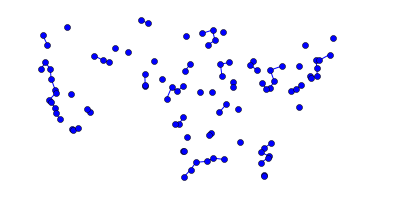

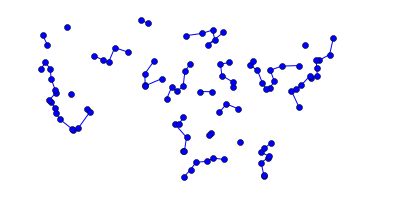

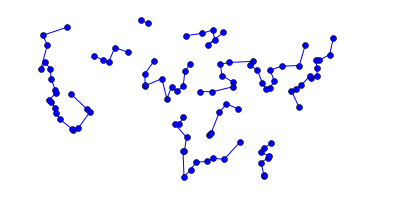

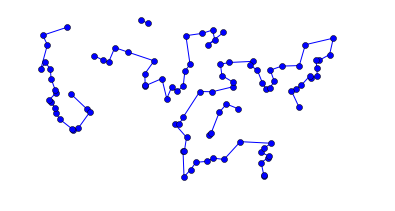

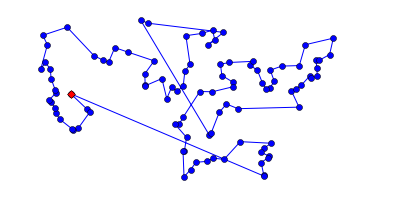

improve_greedy: 100 cities ⇒ tour length 12464 (in 0.025 sec)


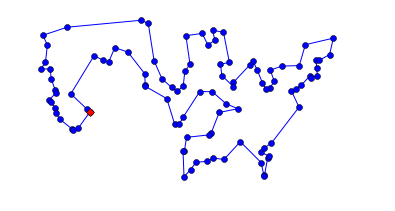

In [40]:
visualize_improve_greedy_tsp(sample(USA, 100), {40, 20, 10, 5});

# Divide and Conquer Strategy

The next general strategy to consider is **divide and conquer**.  Suppose we have an algorithm, like `exhaustive_tsp`, that we can't feasibly apply to a large set of cities, because it is inefficient. We could divide the problem into smaller pieces, and then combine those pieces:

1. Split the set of cities in half.
2. Find a tour for each half.
3. Join those two tours into one.

When *n* is small, then step 2 can be done directly by the inefficient algorithm.  But when *n* is large, step 2 is done with a recursive call, breaking each half into two smaller pieces.
Here's an example with six cities. We split them into two halves of 3 cities each, for which we can easily create tours:

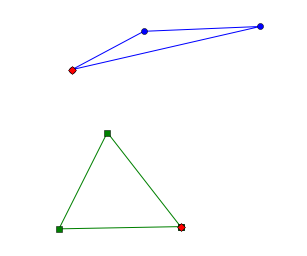

In [41]:
d, a, b, e, c, f = Cities(6)

half1, half2 = [c, a, b], [d, e, f]

plot_tour(half1, 'bo-')
plot_tour(half2, 'gs-')

Now to join the two halves together, the first thing I do is delete a link from each half. There are 3 &times; 3 ways to do that; here's one:

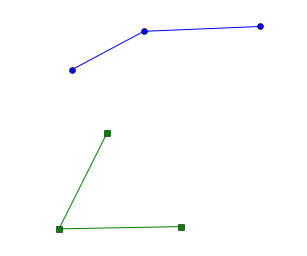

In [42]:
plot_segment(half1, 'bo-')
plot_segment(half2, 'gs-')


Now I connect the two halves back together. There are two ways to do that; this is the better way:

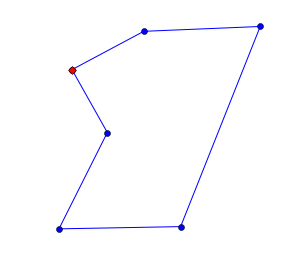

In [43]:
plot_tour(half1 + half2)

Now we have a feel for what we have to do.  I'll call the divide and conquer algorithm `divide_tsp`.  If the size of the set of cities is *n* or less, then find the shortest tour using `exhaustive_tsp`. If there are more than *n* cities, then split the cities in half (with `split_cities`), find a tour for each half (using `divide_tsp` recursively), and join the two tours together (with `join_tours`): 

In [44]:
def divide_tsp(cities, n=6):
    """Find a tour by divide and conquer: if number of cities is n or less, use exhaustive search.
    Otherwise, split the cities in half, solve each half recursively, 
    then join those two tours together."""
    if len(cities) <= n:
        return exhaustive_tsp(cities)
    else:
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1), divide_tsp(half2))
    
# TO DO: functions: split_cities, join_tours

How do we split a set of cities?  My approach is to imagine drawing an axis-aligned rectangle that is just big enough to contain all the cities. If the rectangle  is wider than it is tall, then order all the cities by *x* coordinate and split that ordered list in half.  If the rectangle is taller than it is wide, order and split the cities by *y* coordinate. 

In [45]:
def split_cities(cities):
    "Split cities vertically if map is wider; horizontally if map is taller."
    width  = extent(cities, key=X)
    height = extent(cities, key=Y)
    cities = sorted(cities, key=(X if (width > height) else Y))
    mid    = len(cities) // 2
    return frozenset(cities[:mid]), frozenset(cities[mid:])

def extent(items, key): return max(map(key, items)) - min(map(key, items))

Now for the tricky part: joining two tours together. First we consider all ways of deleting one link from each of the two tours.  If we delete a link from a tour we get a segment.  We are representing segments as lists of cities, the same surface representation as tours.  But there is a difference in their interpretation.  The tour `[c, a, b]` is a triangle of three links, but the segment `[c, a, b]` consists of only two links, from `c` to `a` and from `a` to `b`. The segments that result from deleting a link from the tour `[c, a, b]` are:

     [c, a, b],  [a, b, c],  [b, c, a]

You may recognize these as the *rotations* of the segment `[c, a, b]`. So any candidate combined tour consists of taking a rotation of the first tour, and appending to it a rotation of the second tour, with one caveat: when we go to append the two segments, there are two ways of doing it: either keep the second segment as is, or reverse the second segment.

In [46]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    return shortest_tour(s1 + s2
                         for s1 in segments1
                         for s  in segments2
                         for s2 in (s, s[::-1]))

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

As usual, we can define an **improved** version:

In [47]:
def improve_divide_tsp(cities): return improve_tour(divide_tsp(cities))

Let's divide and conquer! First the 6 cities, then 100 USA cities:

divide, 3: 6 cities ⇒ tour length 1922 (in 0.000 sec)


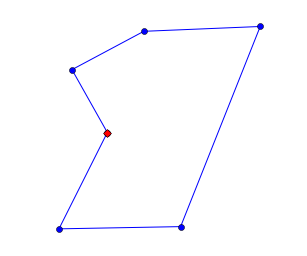

In [48]:
do(bind(divide_tsp, 3), Cities(6))

improve_divide: 100 cities ⇒ tour length 12994 (in 0.207 sec)


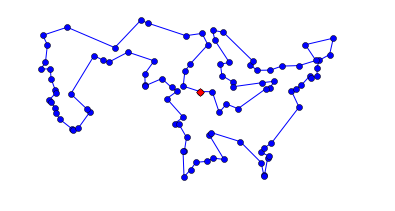

In [49]:
do(improve_divide_tsp, sample(USA, 100))

That's not as good as `improve_greedy_tsp`.

# Shoulders of Giants: Minimum Spanning Tree Algorithm


| ![Joseph Kruskal (Wikipedia)](http://people.inf.elte.hu/hytruongson/Kruskal/J.Kruskal.jpg) |
|----|
| [Joseph Kruskal (Wikipedia)](https://en.wikipedia.org/wiki/Joseph_Kruskal) |



I hope you now believe that you could have come up with some ideas for solving the TSP, using the set of **strategies**. But even if you can't come up with something all on your own, you can follow the **Stand on the Shoulders of Giants Strategy**, also known as the **[Just Google it Strategy](http://bit.ly/XNGt2y)**, in which case you'll no doubt find a giant of a mathematician, [Joseph Kruskal](http://en.wikipedia.org/wiki/Joseph_Kruskal), who, in 1956, published [a paper](http://www.cmat.edu.uy/~marclan/TAG/Sellanes/Kruskal.pdf) that led to an algorithm that
most people would not have thought of on their own (I know I wouldn't have):
> **Minimum Spanning Tree Traversal Algorithm:** *Construct a Minimum Spanning Tree, then do a pre-order traversal.  That will give you a tour that is guaranteed to be no more than twice as long as the minimal tour.* 

What does all this jargon mean? It is part of *[graph theory](https://en.wikipedia.org/wiki/Graph_theory)*, the study of vertexes and links.  Here is a glossary of terms:

* A **graph** is a collection of vertexes and links.
* A **vertex** is a point (such as a city).
* A **link** is an edge between two vertexes. Links have lengths.

* A **directed graph** is a graph where the links have a direction.  We say that the link goes from the **parent** vertex to the **child** vertex.

* A **tree** is a directed graph in which there is one distinguished vertex called the **root** that has no parent; every other vertex has exactly one parent. 

* A **spanning tree** (of a set of vertexes) is a tree that contains all the vertexes.    

* A **minimum spanning tree** is a spanning tree with the smallest possible sum of link lengths.

* A **traversal** of a tree is a way of visiting all the vertexes in some order.

* A **pre-order traversal** means that you visit the root first, then do a pre-order traversal of each of the children.

* A **guarantee** means that, no matter what set of cities you consider, the tour found by the minimum spanning tree traversal algorithm will never be more than twice as long as the shortest possible tour. None of the other algorithms has any guarantee at all (except for `exhaustive_tsp`, which is guaranteed to find the optimal algorithm, if it has enough time to complete).

We will implement a directed graph as a dict of `{parent: [child, ...]}`. Now our plan is:

1. Implement an algorithm to create a minimum spanning tree.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee.

# Creating a Minimum Spanning Tree (`mst`)


Now let's see how to create a minimum spanning tree (or MST).  Kruskal has a very nice algorithm to find MSTs, but with what we have done so far, it will be a bit easier to implement [another Giant](https://en.wikipedia.org/wiki/Robert_C._Prim)'s algorithm:

> **[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm):** *List all the links and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily choose the first city). Now repeat the following until the tree contains all the cities: find the shortest link that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we assign `(A, B)` to be a link in which exactly one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [50]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form 
    {parent: [child...]}, spanning all vertexes."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while len(tree) < len(vertexes):
        (A, B) = first((A, B) for (A, B) in links if (A in tree) ^ (B in tree))
        if A not in tree: (A, B) = (B, A)
        tree[A].append(B)
        tree[B] = []
    return tree

Let's see what a minimum spanning tree looks like:

1089 node Graph of total length: 37868.3


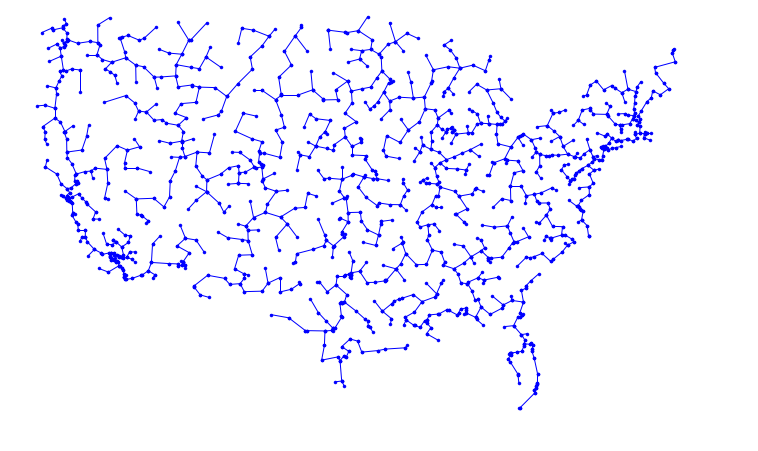

In [51]:
def plot_graph(graph):
    "Given a graph of the form {parent: [child...]}, plot vertexes and links."
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    links    = [(parent, child) for parent in graph for child in graph[parent]]
    total    = sum(distance(p, c) for (p, c) in links)
    print('{} node Graph of total length: {:.1f}'.format(len(vertexes), total))
    if len(graph) > 1000: plt.figure(figsize=(15, 7.5))
    for link in links:
        plot_segment(link, 'b.-')

    
plot_graph(mst(USA))

This looks like a spanning tree.  But can we be sure it is a *minimum* spanning tree?  

1. The output is a **tree** because (1) every city is connected by a path from the root, and (2) every city only gets one parent (we only add a B that is not in tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible link.  Suppose this algorithm produces the tree T. For another putative spanning tree to be shorter, it would have to contain at least one city C whose link from its parent was shorter than the link in T. But that is not possible, because the algorithm always chooses the shortest possible link from C's parent to C.


# Turning a Minimum Spanning Tree into a Tour (`mst_tsp`)


Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [52]:
def mst_tsp(cities):
    "Create a minimum spanning tree and walk it in pre-order, omitting duplicates."
    return Tour(preorder_traversal(mst(cities), first(cities)))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    yield root
    for child in tree.get(root, ()):
        yield from preorder_traversal(tree, child)
        
def improve_mst_tsp(cities): return improve_tour(mst_tsp(cities))

You can think of this as starting at the root of the tree and going around the outside of the tree, as if you were walking with your hand always touching a link, but skipping cities you have already been to.

Let's see what `mst_tsp` can do on the USA map:

mst: 1089 cities ⇒ tour length 58059 (in 0.911 sec)


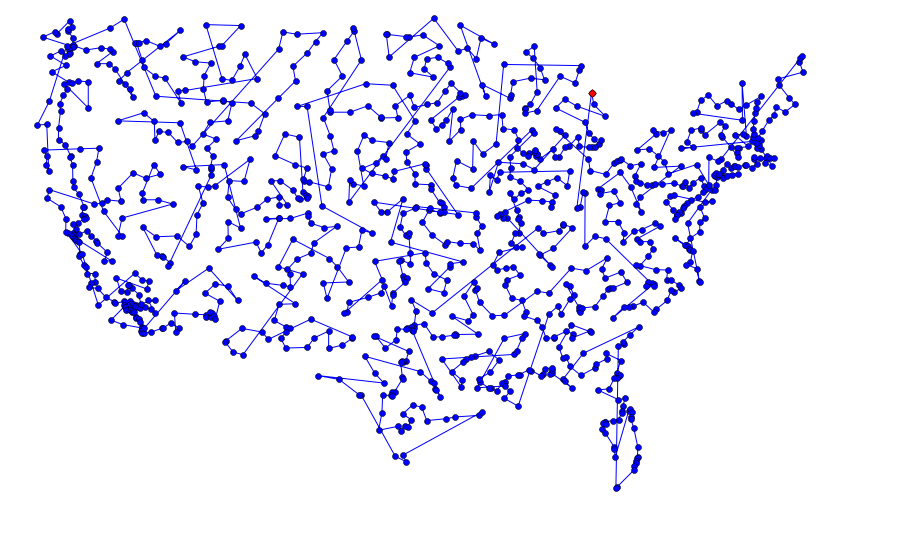

In [53]:
do(mst_tsp, USA)

That's 5,000 miles worse than `nn_tsp`. Why would anyone want to use the minimum spanning tree algorithm, when the nearest neighbor algorithm is simpler to describe and implement, runs faster, and produces shorter tours? 

# Guaranteed Tour Length!

The "giant" thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer. The algorithm  guarantees that the tour length will be no worse than twice as long as the optimal tour.  (And, with a bit more [complication](https://en.wikipedia.org/wiki/Christofides_algorithm), you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the cities with the shortest possible total link length.
2. So if you could follow each link in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip to the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some links twice, and some links once.  Hence the total length of the tour would be at most twice the spanning tree, and thus at most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms do better than the minimum spanning tree, and the improved versions of those algorithms do significantly better, on the maps that we actually see. 

# Shoulders of Giants: Held-Karp Algorithm: `held_karp_tsp`


| ![](http://archive.computerhistory.org/resources/still-image/IBM/IBM_People/IBM.3_mathematicians_Held_Shareshian_Karp.ca1964.102650390.lg.jpg) |
|----|
| [Held, Shareshian, Karp (Computer History Museum)](http://www.computerhistory.org/collections/catalog/102650390) |

| ![](http://imgs.xkcd.com/comics/travelling_salesman_problem.png) |
|----|
| [xkcd 399](http://xkcd.com/399/) |


Another algorithm that shows up with a literature search is the [Held-Karp Dynamic Programming Algorithm](http://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm), named after giants [Michael Held](http://www.computerhistory.org/collections/catalog/102650390) and [Richard Karp](http://en.wikipedia.org/wiki/Richard_M._Karp). It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any programming tricks, it can go quite a bit further than `exhaustive_tsp`.  That is because `exhaustive_tsp` is O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  How did Held and Karp achieve this speedup?  They noticed that `exhaustive_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Here's the key idea:


>*Given a start city A, an end city C, and a set of middle cities Bs, then out of all the possible segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest of those segments could ever be part of an optimal tour.*

Of course, we don't know that the optimal tour goes through exactly those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  Why is that such a big deal? Suppose we are considering segments of the form:

     [A, {B1, ... B10}, C, {D1, ... D10}, E]
     
That is, segments that start with A, then have have 10 B<sub>i</sub> cities in some order, then C, then 10 D<sub>j</sub> cities in some order, then E. With the Exhaustive Search algorithm, we have to consider all orderings of B<sub>i</sub> and all orderings of D<sub>j</sub>, so overall there would be (10!)<sup>2</sup> &approx; 13 trillion orderings of this form. But with Held-Karp, we consider the B<sub>i</sub> and D<sub>j</sub> separately, and chose the best segment from each, giving us only 2 &times; 10! &approx; 7 million orderings to consider. (Actually it is even better than that, because we use Held-Karp recursively to split the B<sub>i</sub> and D<sub>j</sub> into pieces.) 

So far we have only been talking about segments.  We know that the TSP is defined for tours, not segments. So even if we find the shortest possible segment, it might not be the shortest possible tour.  But here's something we do know: a tour has to end somewhere.  So just find the shortest segment from the start city, `A`, to each possible end city, `C`.   Out of those segments, choose the one that is the shortest tour. That gives us our algorithm:

In [54]:
def held_karp_tsp(cities):
    """The Held-Karp shortest tour of this set of cities.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    shortest_segment.cache_clear() # Start a new problem
    return shortest_tour(shortest_segment(A, cities - {A, C}, C)
                         for C in cities - {A})

# TO DO: function: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`, the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@cache` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times. In the function `held_karp_tsp` we clear the cache at the start of each new problem.

In [55]:
@cache(None)
def shortest_segment(A, Bs, C):
    "The shortest segment starting at A, going through all Bs, and ending at C."
    if not Bs:
        return [A, C]
    else:
        return min((shortest_segment(A, Bs - {B}, B) + [C] for B in Bs),
                   key=segment_length)
            
def segment_length(segment):
    "The total of distances between each pair of consecutive cities in the segment."
    # Same as tour_length, but without distance(tour[0], tour[-1])
    return sum(distance(segment[i], segment[i-1]) 
               for i in range(1, len(segment)))

That's all there is to it.  Let's compare `exhaustive_tsp` with `held_karp_tsp` on 10 city tours:

exhaustive: 10 cities ⇒ tour length 2720 (in 1.614 sec)


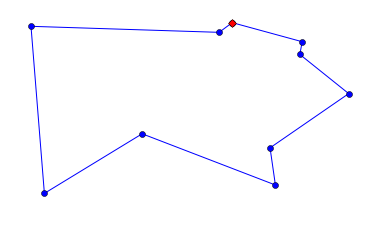

In [56]:
do(exhaustive_tsp, Cities(10))

held_karp: 10 cities ⇒ tour length 2720 (in 0.034 sec)


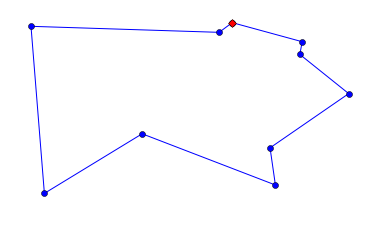

In [57]:
do(held_karp_tsp, Cities(10))

We see that `held_karp_tsp` is a lot faster.  We can extend into uncharted territory  beyond the reach of  `exhaustive_tsp`:

held_karp: 18 cities ⇒ tour length 2771 (in 45.141 sec)


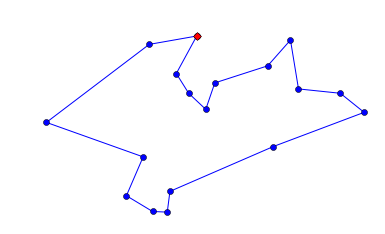

In [58]:
do(held_karp_tsp, Cities(18))

Not bad! To see how much time we save using `held_karp_tsp` over `exhaustive_tsp`, we can extrapolate from the timings we've done, using the fact that Held-Karp is *O*(*n*<sup>2</sup> 2<sup>*n*</sup>) while Exhaustive Search is *O*(*n*!), to get this table:


|*n*|Exhaustive Search|Held Karp|
|---|---|---|
|10| 2 secs                | 0.04 secs |
|12|&approx; 4 mins   | 0.25 secs|
|15|&approx; 8 days |3 secs|
|18|&approx; 112 years| 43 secs|
|25|&approx; <a href="https://www.google.com/search?q=2+seconds*25!+%2F+10!+in+years">270 billion years</a>|&approx; 3 hours|
|50|&approx; 10<sup>50</sup> years</a>|&approx; 45,000 years|


So if we had the patience to wait 3 hours, `held_karp_tsp` could give us an answer that saves 270 billion years of computing with `exhaustive_tsp`.  The original Held-Karp algorithm had refinements that allowed it to handle 50-city sets in hours, not milleniums, and could do so even with 1970s-era computing power! See **Branch and Cut** below.

We have one more trick to try:

# Ensemble Strategy: `ensemble_tsp`

When we have several optimization algorithms and we're not sure which is best, we can always try them all and take the best result:

In [59]:
ensemble = {rep_improve_nn_tsp, improve_greedy_tsp, improve_mst_tsp, improve_divide_tsp}

def ensemble_tsp(cities, algorithms=None): 
    "Apply an ensemble of algorithms to cities and take the shortest resulting tour."
    return shortest_tour(tsp(cities) for tsp in (algorithms or ensemble))

ensemble: 100 cities ⇒ tour length 12467 (in 0.337 sec)


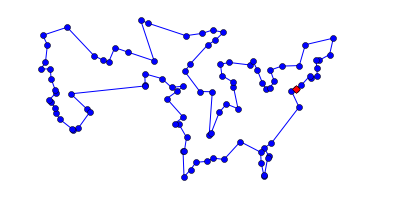

In [60]:
do(ensemble_tsp, set(sample(USA, 100)))

# Review

Here are the algorithms we developed, sorted by strategy:

- **Brute Force Strategy**: `exhaustive_tsp`
- **Greedy Strategy**: `nn_tsp`, `greedy_tsp`
- **Divide and Conquer Strategy**: `divide_tsp`
- **Ensemble Strategy**: `rep_nn_tsp`, `ensemble_tsp`
- **Giant Shoulders Strategy**: `mst_tsp`, `held_karp_tsp`
- **Iterative Improvement Strategy**: `improve_nn_tsp`, `improve_greedy_tsp`, `improve_divide_tsp`,  `rep_improve_nn_tsp`, `improve_mst_tsp`


# Benchmark Experiments on Algorithms

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test suite** of problems. If the test suite is large enough, the results will have statistical significance. First we'll define `TestSuite`. It passes a different `seed` to `sample` each time, so we get a different set of cities each time.

In [61]:
def TestSuite(n, k, cities=USA):
    "Return n different samples from cities, each consisting of k cities."
    return tuple(frozenset(sample(cities, k, seed=(n, k, i)))
                 for i in range(n))

In [62]:
# A tiny test of sets of 2 cities each:
TestSuite(4, 2)

(frozenset({(-3726.24+2437.08j), (-4401.6+2889.7200000000003j)}),
 frozenset({(-3672+2492.9700000000003j), (-3684.96+2773.8j)}),
 frozenset({(-5460.96+2934.57j), (-5628.96+2337.7200000000003j)}),
 frozenset({(-4120.799999999999+2317.02j), (-5721.6+2359.8j)}))

Next, the function `benchmark` takes as input a TSP function and a test suite, runs the function on each city set in the suite, and returns two values: the list of tour lengths that the function produced, and the average run time of the function. (Note that I *cache* the results, so that if you call benchmark a second time, and it has already done the computation, it just looks up the result rather than tediously re-running it.)

In [63]:
@cache(None)
def benchmark(algorithm, tests):
    "Benchmark one TSP algorithm on a test suite; return ([tour_lengths], average_time)"
    t0      = clock()
    lengths = [tour_length(algorithm(cities)) for cities in tests] 
    t1      = clock()
    return lengths, (t1 - t0) / len(tests)

# Boxplots

A **boxplot** is a standard statistical visualization tool. I'll plot them first, then explain them. 

In [64]:
def boxplots(algorithms, tests):
    "Draw a boxplot for each of the functions executing the tests."
    lengthlists, times = unzip(benchmark(tsp, tests) for tsp in algorithms)
    best   = min(map(median, lengthlists))
    labels = [boxplot_label(A, L, T, best) 
              for (A, L, T) in zip(algorithms, lengthlists, times)]
    plt.figure(figsize=(15, 7.5))
    plt.grid(axis='y')
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.boxplot(lengthlists, labels=labels, showmeans=True, whis=(10, 90), sym='o', notch=True)
    plt.title("Comparison  on {} sets of Cities({})"
              .format(len(tests), len(tests[0])), fontsize=14)

def boxplot_label(tsp, lengths, T, best):
    return '{}\n{:.0f} ms\n{:.0f} mean len\n{:.0f} med len\n{:.3f} med ratio'.format(
           name(tsp), T * 1000, mean(lengths), median(lengths), median(lengths) / best)

def unzip(sequences): return zip(*sequences)

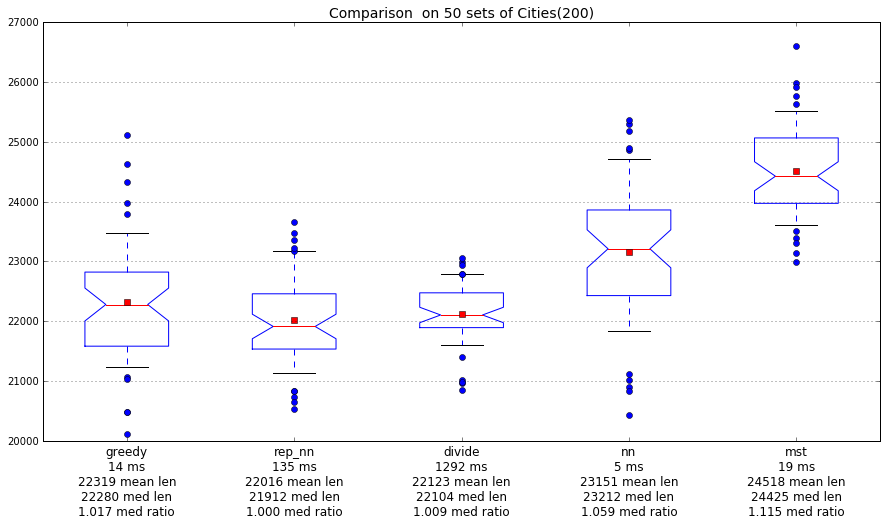

In [65]:
# boxplots for the 5 basic approximate algorithms:
basic5 = [greedy_tsp, rep_nn_tsp, divide_tsp, nn_tsp, mst_tsp]

boxplots(basic5, TestSuite(50, 200))

Each column represents a data set (in this case, the 50 tour lengths for one algorithm) with a box covering the first to third quartiles of the data; inside the box is a horizontal line indicating the median and a marker indicating the mean. The 10% and 90%  intervals are the "whiskers" coming out of the top and bottom of the box, and individual points outside that range are shown as dots. The "notches" in the sides of a boxes represent the 95% confidence interval on the median: if two boxes' notches do not overlap, that is strong evidence that the true medians of the algorithms differ. The **label** at the bottom of each column gives the name of the algorithm, the average run time in milliseconds, the mean and median tour length, and the ratio of the median tour length of this algorithm to the median tour length of the best algorithm in this boxplot.

This plot says that the first three algorithms all did about the same in tour length (although the greedy algorithm was much faster). The minimum spanning tree algorithm produces by far the longest tours. Nearest neighbor is fastest, while divide and conquer is slowest.

# Compare Rankings

I'd also like to know for how many different problems each algorithm was best, or second best, etc. I will define a function called `rankings` to do that. I'll also define  `compare` to call both `boxplots` and `rankings`:

In [66]:
def compare(algorithms, tests=TestSuite(50, 200)):
    "Compare TSP algorithms on a test suite."
    boxplots(algorithms, tests)
    plt.show()
    rankings(algorithms, tests)
    
def rankings(algorithms, tests):
    "Print a table of how often each algorithm had each rank: you get a #1 if you were shortest."
    N = len(algorithms)
    lengthlists = [benchmark(tsp, tests)[0] for tsp in algorithms]
    # ordered[i] is all tour lengths (for all algorithms) for the i-th problem, sorted
    ordered = [sorted(L) for L in zip(*lengthlists)]
    fmt = ('{:>4}' * len(algorithms) + ' | {}').format
    print(fmt(*['#' + str(i + 1) for i in range(N)], 'Algorithm'))
    print(' ---' * N + ' | ---------')
    for alg, lengths in zip(algorithms, lengthlists):
        ranks = Counter(ordered[i].index(lengths[i]) for i in range(len(tests)))
        print(fmt(*[ranks[i] for i in range(N)], name(alg)))

The top line of the rankings says the greedy algorithm was #1 (had the shortest tour) for 19 out of the 40 problems, came in second  for 10 problems,  third 9 times, and fourth twice. The `rep_nn_tsp` algorithm was not quite as good, coming in first 11 times, while the MST algorithm was terrible, coming in last 39 times.


# Comparsion of Improved Algorithms

Now let's compare the **improved** versions of these algorithms:

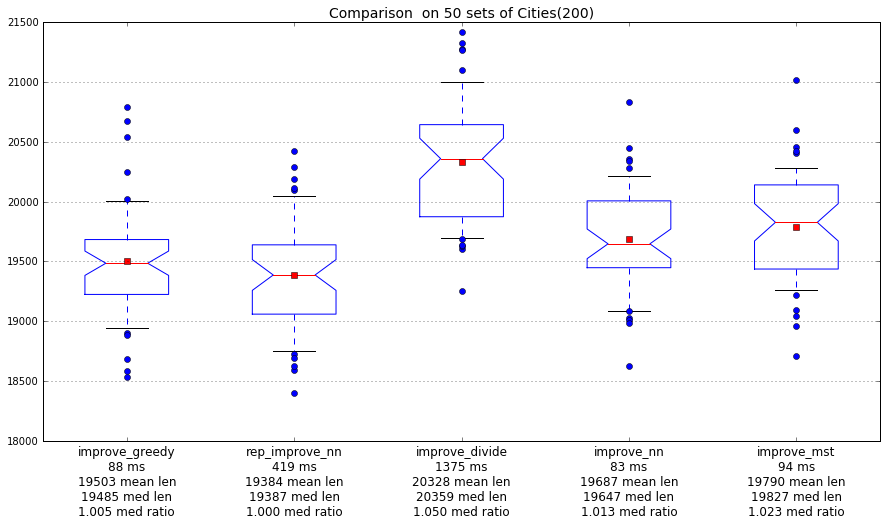

  #1  #2  #3  #4  #5 | Algorithm
 --- --- --- --- --- | ---------
  13  16  18   1   2 | improve_greedy
  24  17   4   5   0 | rep_improve_nn
   0   1   1  11  37 | improve_divide
  10   8  13  16   3 | improve_nn
   3   8  14  17   8 | improve_mst


In [67]:
improved = [improve_greedy_tsp, rep_improve_nn_tsp, improve_divide_tsp, improve_nn_tsp, improve_mst_tsp]

compare(improved)

The `improve_greedy_tsp` and `rep_improve_nn_tsp` algorithms give the shortest tours. One surprising result is that the divide and conquer algorithm was not improved much; perhaps the re-assembly steps of divide and conquer are already doing similar things to what `improve_tour` does. The minimum spanning tree algorithm is no longer terrible.
To make sense of the rankings: the top line says that `improve_greedy` was #1 (had the shortest tour) on 13 of the 50 problems, was #2 on 16 problems, and so on, while `rep_improve_nn` actually had more #1 finishes with 24. The big loser was `improve_divide`, with 0 first place finishes and 37 last place finishes.

# Comparison of *k* Values for `rep_improve_nn_tsp`

What's a good value for the *k* parameter for the repetitive improved nearest neighbor algorithm?

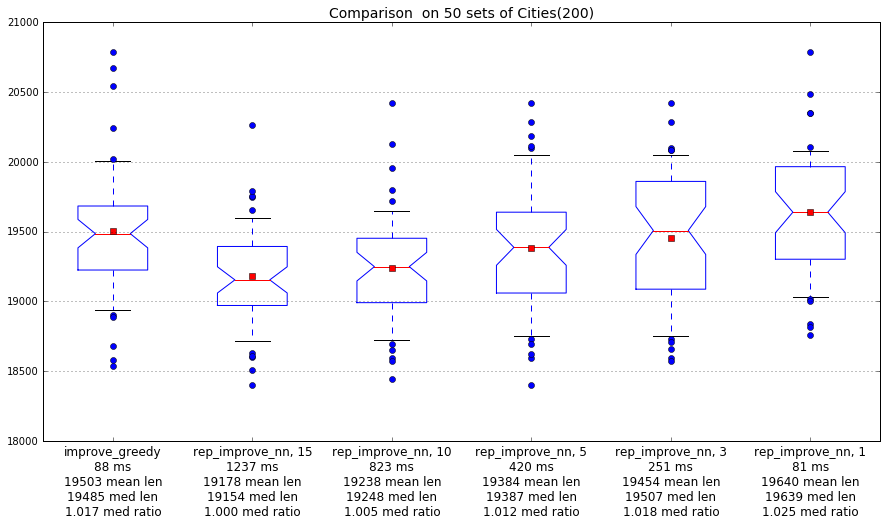

  #1  #2  #3  #4  #5  #6 | Algorithm
 --- --- --- --- --- --- | ---------
   3   8   6   8  11  14 | improve_greedy
  28  12   3   3   3   1 | rep_improve_nn, 15
  14  12  16   5   3   0 | rep_improve_nn, 10
   6   5  17  13   4   5 | rep_improve_nn, 5
   4   7   8  14   8   9 | rep_improve_nn, 3
   1   4   2   5  17  21 | rep_improve_nn, 1


In [68]:
compare([improve_greedy_tsp] + [bind(rep_improve_nn_tsp, k) for k in (15, 10, 5, 3, 1)])

We do get shorter tours as we increase the reptitions, but of course we pay a penalty in run time. With *k*=3,
`rep_improve_nn_tsp` is roughly comparable to `improve_greedy_tsp` (although the later is twice as fast). With *k*=15 the tours are 2.5% shorter than with *k*=1, but the run time is 15 times longer. 

# Comparison of Ensemble Strategy

Since no one algorithm always dominates the others, maybe it is time for the **ensemble strategy**:

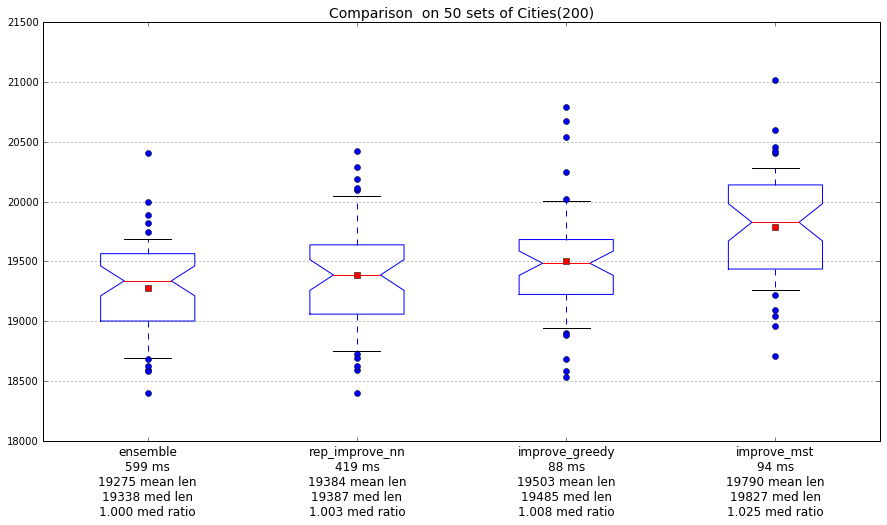

  #1  #2  #3  #4 | Algorithm
 --- --- --- --- | ---------
  50   0   0   0 | ensemble
  31   0  13   6 | rep_improve_nn
  16   0  26   8 | improve_greedy
   3   0  11  36 | improve_mst


In [69]:
ensemble = (rep_improve_nn_tsp, improve_greedy_tsp, improve_mst_tsp)

compare((ensemble_tsp, *ensemble))

The `ensemble_tsp` algorithm produces the shortest tours yet, because it gets contributions from both `rep_improve_nn_tsp` and `improve_greedy_tsp` (and, for just 3 out of 50 problems, from `improve_mst_tsp`). Note that in the rankings, for every problem there is a two way tie for first between the `ensemble_tsp` algorithm and whichever member of the ensemble contributed that tour. That's why there are 100 (not 50) entries in the "#1" column, and 0 in the "#2" column. 

Let's see if the results are different for different-sized city sets:

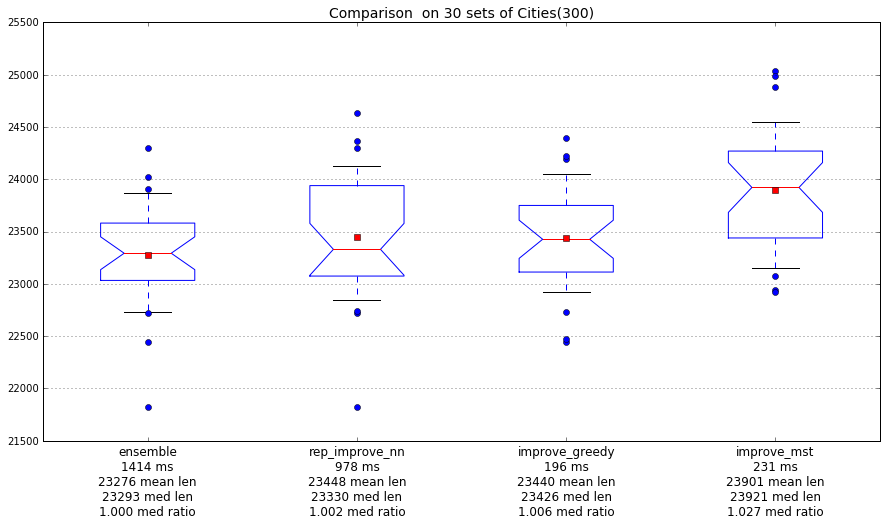

  #1  #2  #3  #4 | Algorithm
 --- --- --- --- | ---------
  30   0   0   0 | ensemble
  14   0  14   2 | rep_improve_nn
  15   0  10   5 | improve_greedy
   1   0   6  23 | improve_mst


In [70]:
compare((ensemble_tsp, *ensemble), TestSuite(30, 300))

A similar picture.

# Comparing Precise Algorithms

Here I compare the two precise algorithms, Exhaustive Search and Held-Karp, to the (approximate) ensemble algorithm. I won't bother with `rankings`, because the precise algorithms always tie for first. I'll try both 9 and 10-city test suites:

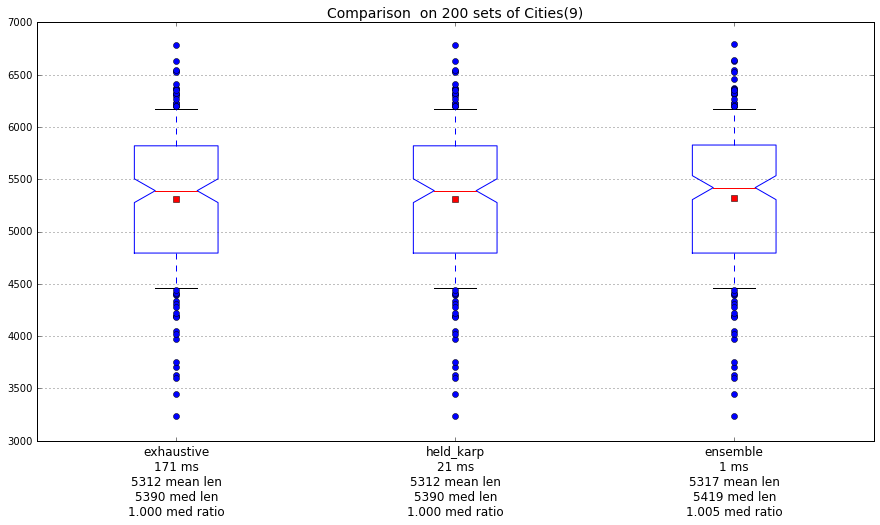

In [71]:
boxplots([exhaustive_tsp, held_karp_tsp, ensemble_tsp], TestSuite(200, 9))

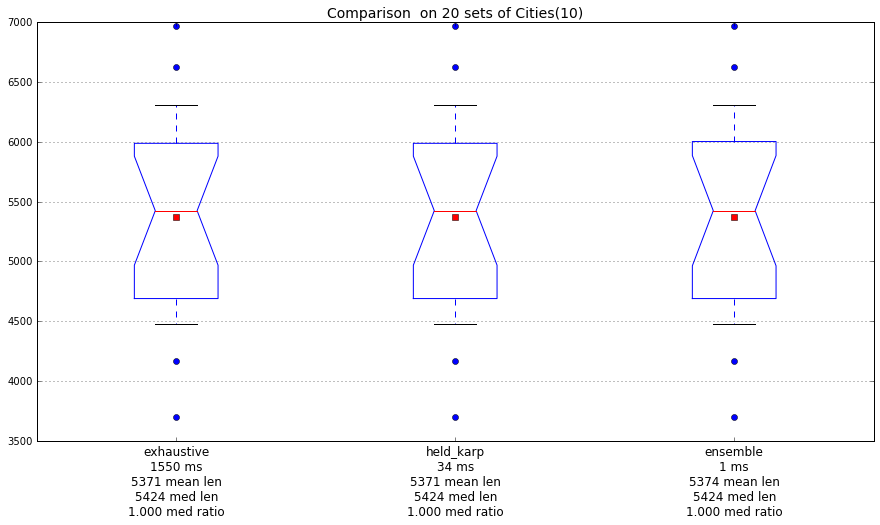

In [72]:
boxplots([exhaustive_tsp, held_karp_tsp, ensemble_tsp], TestSuite(20, 10))

This says that while `ensemble_tsp` does not quite give a guarantee of an optimal tour, in practice on random city sets it performs almost exactly the same as the precise algorithms, only faster.


# Further Explorations


That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* **Branch and Cut**: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* **Linear programming**: Look up the topic "linear programming" and see how it applies to TSP.
* **Heuristic Algorithms**: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, *ant colony optimization algorithms* make random choices of which link to follow, and then the links that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones. *Simulated annealing* takes its inspiration from metallurgy.
* The **[Lin-Kernighan heuristic](http://akira.ruc.dk/~keld/research/LKH/LKH-1.3/DOC/LKH_REPORT.pdf)** is a generalization of `improve_tour` that sometimes splits the tour into three pieces, not two, and considers all ways to put it back together. With this and other tricks, approximate algorithms  can handle hundreds of thousands of cities and come within 0.01% of the shortest possible tour.
* The **[Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm)** gives a guarantee of 3/2 the optimal tour length (improving on the minimum-spanning-tree guarantee of 2).
* **improved** as a function: we defined a lot of one-line functions that just call another algorithm, and then call `improve_tour` on the result.  Can you write a function, `improved(algorithm)`, which takes a TSP algorithm as argument, and returns an improved TSP algorithm that does the original algorithm and then calls `improve_tour` on the result? Make sure it handles extra arguments, and has a readable function name.
* Why does `mst_tsp` produce a guaranteed result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_links_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster?
* **[William Cook](https://www.math.uwaterloo.ca/~bico/)** has a comprehensive 
[web page](http://www.math.uwaterloo.ca/tsp/) on the TSP, as well as a great 
[book](https://press.princeton.edu/titles/9531.html) and a
[draft chapter](http://www.math.uwaterloo.ca/~bico/papers/comp_chapter1.pdf) on Discrete Optimization featuring TSP. Like my notebook here, Cook's chapter goes through a variety of algorithms for TSP, describing each one in prose and code. His coding style is different because he uses C (in an imperative style) while I used Python (in a functional style).  His code is much more efficient (but if it is 100 times faster, that might only mean two more cities). Cook  chooses a different set of algorithms to explore, with
more emphasis on optimizing algorithms that find guaranteed shortest tours. I find his explanations and code
are both beautiful and concise, and I think it is very interesting that
there can be two quite different approaches, which (in my opinion) both turn out very well. 
* If you are heavily into math, there's a [taxonomy](http://cstheory.stackexchange.com/questions/9241/approximation-algorithms-for-metric-tsp) of solutions.
* What else are you interested in?